## Лабораторная работа 8. Бустинги!

В этой домашке познакомимся с новым методом ансамблирования — бустингом, а также немножко доработаем фичи для предыдущего датасета, чтобы получать лучшее качество на тестовом датасете.

Контест https://contest.yandex.ru/contest/55027

#### Дискуссия
Краеугольными камнями машинлернера являются данные и модели: применили более качественную модель — получили прирост метрик, нашли дополнительные данные или сгенерировали информативные признаки, которые наша модель не может сгенерировать сама — получили прирост метрик. Поскольку мы продолжаем тему ансамблирования, то разберемся с ультимативным методом ансамблирования — бустингом, который до сих пор дает топовые места в табличных соревнованиях и используется в качестве модели верхнего уровня в сложных стэкинговых пайплайнах Яндекса.

#### Адаптивный бустинг
Первой задачей будет имплементация алгоритма SAMME.R для адаптивного бустинга — последовательного обучения слабых классификаторов с **перевзвешенными** объектами обучающей выборки для уточнения предсказаний именно на примерах с сильно отличающимися от истинных предсказаниями.

Наша имплементация будет опираться на авторскую монографию ([ссылка](https://hastie.su.domains/Papers/samme.pdf)).

Прочтите оттуда описание алгоритма 4 и используйте следующие подсказки для полноценной имплементации:
* В качестве базового классификатора применяйте (и держите в голове при написании кода) `DecisionTreeClassifier` из `sklearn`, т.к. он умеет работать со взвешенными объектами обучающей выборки. В качестве бонусного задания подумайте, как модифицировать нашу реализацию деревьев, чтобы она тоже умела работать с приоритетными объектами. Однако, заметьте, что бустить этим алгоритмом можно не только деревья, но и другие модели, которые могут предсказывать вероятности, например, логистическую регрессию, перцептрон и другие.
* Заметьте, что в статье истинные метки классов пересчитаны некоторым нестандартным образом (формула (2) похожа на OneHot, но сглаженный), там это мотивировано вероятностной постановкой задачи. На практике так часто делают, чтобы улучшить протекание градиента в нейросетях или распространение информации в весах бустинга, поскольку неверные предикты не зануляются совсем при пересчете весов.
* При подсчете вероятности класса для данного объекта берется сумма скоров, предсказаных базовыми классификаторами, потом перевзвешивается при помощи `softmax`, то есть формула для вероятности принимает вид (подумайте, чему эта формула соответствует при подстановке $h$ через вероятность):
$$
    P(y_i = k|x_i) = \frac{\exp\left\{\frac{1}{K-1}\sum_{m=1}^Mh_k^{(m)}(x_i)\right\}}{\sum_{k'=1}^K\exp\left\{\frac{1}{K-1}\sum_{m=1}^Mh_{k'}^{(m)}(x_i)\right\}}
$$

**1. (1 балл) Сдайте реализацию перевзвешивания в адаптивном бустинге в контест.**

**2. (2 балла) Сдайте реализацию обучения классификатора в контест.**

**3. (2 балла) Сдайте реализацию предсказания в адаптивном бустинге в контест.**

In [1]:
!pip install numpy==1.24.0 pandas==1.5.3 scikit-learn==1.1.3

In [2]:
import contextlib
import inspect
import json
import os
import pathlib
import typing as tp
import uuid

import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics._scorer import _check_multimetric_scoring
from sklearn.model_selection._validation import _score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

In [3]:
class MyAdaBoostClassifier:
    """
    Multiclass AdaBoost implementation with SAMME.R algorithm
    """
    big_number = 1 << 32
    eps = 1e-8

    def __init__(
            self,
            n_estimators: int,
            base_estimator: tp.Type[sklearn.base.BaseEstimator],
            seed: int,
            **kwargs
    ):
        """
        :param n_estimators: count of estimators
        :param base_estimator: base estimator (practically tree classifier)
        :param seed: global seed
        :param kwargs: keyword arguments of base estimator
        """
        self.n_classes = None
        self.error_history = []  # this is to track model learning process
        self.n_estimators = n_estimators
        self.rng = np.random.default_rng(seed)
        self.base_estimator = base_estimator
        self.base_estimator_kwargs = kwargs
        # deduce which keywords are used to set seed for an estimator (sklearn or own tree implementation)
        signature = inspect.signature(self.base_estimator.__init__)
        self.seed_keyword = None
        if 'seed' in signature.parameters:
            self.seed_keyword = 'seed'
        elif 'random_state' in signature.parameters:
            self.seed_keyword = 'random_state'
        self.estimators = []

    def create_new_estimator(
            self,
            seed: int
    ):
        """
        create new base estiamtor with proper keywords
        and new *unique* seed
        :param seed:
        :return:
        """
        estimator_kwargs = self.base_estimator_kwargs.copy()
        if self.seed_keyword:
            estimator_kwargs[self.seed_keyword] = seed
        estimator = self.base_estimator(**estimator_kwargs)
        return estimator

    def get_new_weights(
            self,
            true_labels: np.ndarray,
            predictions: np.ndarray,
            weights: np.ndarray
    ):
        """
        Calculate new weights according to SAMME.R scheme
        :param true_labels: [n_classes]
        :param predictions: [n_samples, n_classes]
        :param weights:     [n_samples]
        :return: normalized weights for next estimator fitting
        """
        # SAMME
        # w = np.sum(weights) # default 1
        # err = weights.T @ (true_labels != predictions).astype(int) / w
        # alpha = np.log((1 - err) / err) + np.log(n_classes - 1)
        # new_weights = weights.T * np.exp(alpha * (true_labels != predictions).astype(int))
        # return new_weights
        # SAMME.R
        k = self.n_classes
        n = len(true_labels)
        y = np.full((n, k), 1 / (1 - k))
        y[np.arange(n), true_labels] = 1
        coef = (1 - k) / k
        preds = np.sum(y * np.log(predictions + MyAdaBoostClassifier.eps), axis=1)
        w = weights * np.exp(coef * preds)
        sum_w = np.sum(w)
        new_weights = w / sum_w
        return new_weights

    @staticmethod
    def get_estimator_error(
            estimator: sklearn.base.BaseEstimator,
            X: np.ndarray,
            y: np.ndarray,
            weights: np.ndarray
    ):
        """
        calculate weighted error of an estimator
        :param estimator:
        :param X:       [n_samples, n_features]
        :param y:       [n_samples]
        :param weights: [n_samples]
        :return:
        """
        w = np.sum(weights) # default 1
        predictions = estimator.predict(X)
        error = weights.T @ (y != predictions).astype(int) / w
        return error

    def fit(
            self,
            X: np.ndarray,
            y: np.ndarray
    ):
        """
        sequentially fit estimators with updated weights on each iteration
        :param X: [n_samples, n_features]
        :param y: [n_samples]
        :return: self
        """
        self.error_history = []
        # compute number of classes for internal use
        self.n_classes = len(np.unique(y))
        # init weights uniformly over all samples
        n, m = X.shape
        weights = np.full(n, 1. / n)
        # sequentially fit each model and adjust weights
        for seed in self.rng.choice(
                max(MyAdaBoostClassifier.big_number, self.n_estimators),
                size=self.n_estimators,
                replace=False
        ):
            # add newly created estimator
            self.estimators.append(self.create_new_estimator(seed))
            # fit added estimator to data with current sample weights
            self.estimators[-1].fit(X, y, sample_weight=weights)
            # compute probability predictions
            predictions = self.estimators[-1].predict_proba(X)
            # calculate weighted error of last estimator and append to error history
            weighted_error = self.get_estimator_error(self.estimators[-1], X, y, weights)
            self.error_history.append(weighted_error)
            # compute new adjusted weights
            weights = self.get_new_weights(y, predictions, weights)

        return self

    @staticmethod
    def softmax(X):
        exp_el = np.exp(X)
        sum_exp = np.sum(exp_el, axis=1, keepdims=True)
        return exp_el / sum_exp

    def predict_proba(
            self,
            X: np.ndarray
    ):
        """
        predicts probability of each class
        :param X: [n_samples, n_features]
        :return: array of probabilities of a shape [n_samples, n_classes]
        """
        n, m = X.shape
        probailities = np.zeros((n, self.n_classes))
        # calculate probabilities from each estimator and average them, clip logarithms using self.eps
        for estimator in self.estimators:
            prediction = estimator.predict_proba(X)
            cliped_prediction = np.clip(prediction, MyAdaBoostClassifier.eps, 1 - MyAdaBoostClassifier.eps)
            log_predictions = np.log(cliped_prediction)
            probailities += log_predictions
        # use softmax to ensure probabilities sum to 1, use numerically stable implementation
        probas = self.softmax(probailities)
        return probas

    def predict(
            self,
            X: np.ndarray
    ):
        """
        predicts class (use predicted class probabilities)
        :param X: [n_samples, n_features]
        :return: array class predictions of a shape [n_samples]
        """
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        return predictions

Воспользуемся полюбившейся библиотекой, чтобы смотреть на предсказания

In [4]:
!pip install mlxtend

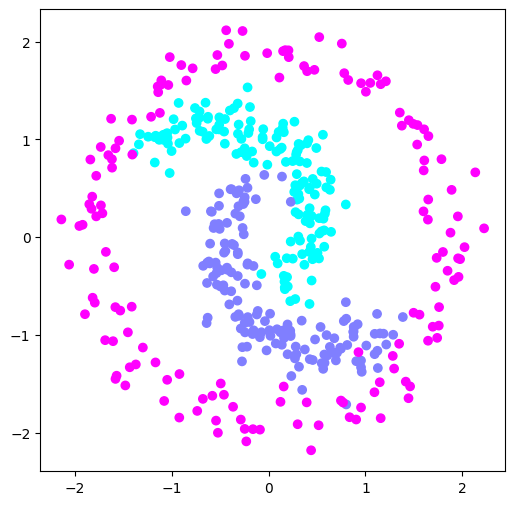

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_moons


def make_sunny_moons(n_sun=50, n_moons=100, noise=0.0, sun_radius=1.9, theta=None):
    X_moons, y_moons = make_moons(n_samples=n_moons, noise=noise, random_state=0xC0FFEE)
    if not n_sun:
        return X_moons, y_moons

    rng = np.random.default_rng(0xC0FFEE)
    angles = np.arange(0, 2 * np.pi, 2 * np.pi / n_sun)
    X_sun = sun_radius * np.column_stack([np.cos(angles), np.sin(angles)]) + np.array([0.5, 0.25])
    X_sun += rng.normal(scale=noise, size=X_sun.shape)
    y_sun = 2 * np.ones(n_sun)

    X = np.vstack([X_moons, X_sun])
    y = np.concatenate([y_moons, y_sun]).astype(int)
    X -= X.mean(axis=0)

    if theta is None:
        theta = np.pi / 4
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    X = X @ R

    return X, y


X, y = make_sunny_moons(n_sun=150, n_moons=300, noise=0.15)
_ = plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='cool')
plt.show();

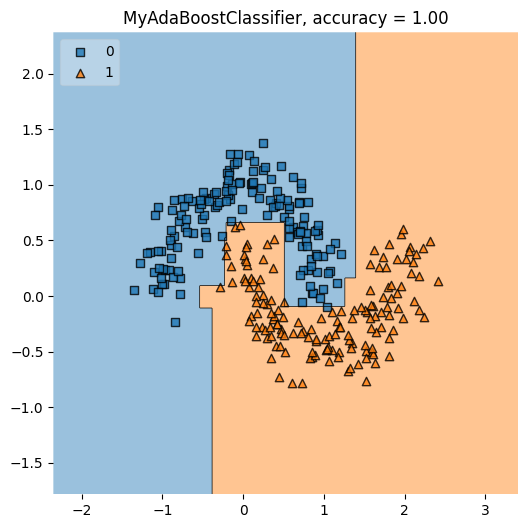

In [10]:
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score


def make_clf_plot(classifier, axis):
    classifier.fit(X, y)
    plot_decision_regions(X, y, clf=classifier, legend=2, ax=axis)
    accuracy = accuracy_score(y, classifier.predict(X))
    axis.set_title(f"{classifier.__class__.__name__}, accuracy = {accuracy:2.2f}")


_ = plt.figure(figsize=(6, 6))
axis = plt.axes()
clf = MyAdaBoostClassifier(n_estimators=10, base_estimator=DecisionTreeClassifier, max_depth=3, seed=42)
make_clf_plot(clf, axis)

Теперь посмотрим на процесс обучения

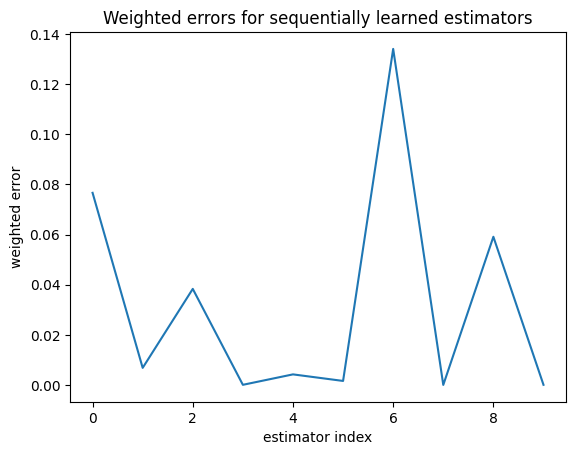

Last estimator weighted error is 0.000


In [11]:
plt.plot(clf.error_history)
plt.title('Weighted errors for sequentially learned estimators')
plt.xlabel('estimator index')
plt.ylabel('weighted error')
plt.show()
print(f'Last estimator weighted error is {clf.error_history[-1]:0.3f}')

Видим, что ошибка последнего близка к нулю. Предположите, как будет изменяться ошибка при добавлении большего числа базовых классификаторов? \
Давайте теперь проверим ваше предположение!

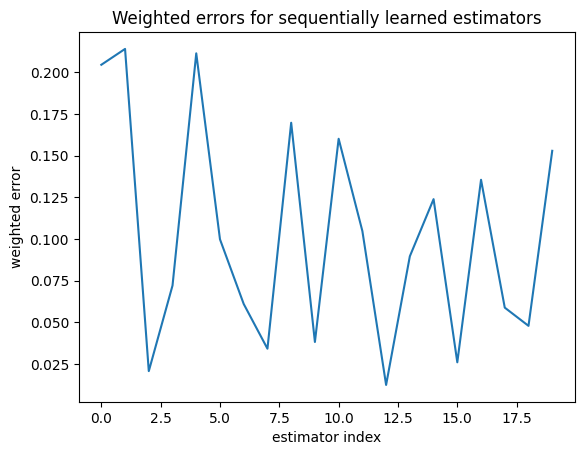

Last estimator weighted error is 0.153


In [9]:
clf = MyAdaBoostClassifier(n_estimators=20, base_estimator=DecisionTreeClassifier, max_depth=3, seed=42)
clf.fit(X, y)
plt.plot(clf.error_history)
plt.title('Weighted errors for sequentially learned estimators')
plt.xlabel('estimator index')
plt.ylabel('weighted error')
plt.show()
print(f'Last estimator weighted error is {clf.error_history[-1]:0.3f}')

Попытайтесь объяснить, почему так происходит?

<details>

  <summary><b>Нажмите однократно, чтобы раскрыть</b></summary>

Поскольку это взвешенная ошибка последнего классификатора, как только мы выучиваем какую-то группу тяжелых примеров, они начинают предсказываться корректно и больший вклад начинают делать примеры, которым мы на данном шаге не уделили внимания. В целом error_rate слабых классификаторов и не должен сходится к нулю, но их ансамбль работает на порядок лучше из-за разнообразия, что мы и видели выше на близкой к 1 accuracy.

</details>

Сравните такой взвешенный ансамбль деревьев со случайным лесом из `sklearn`

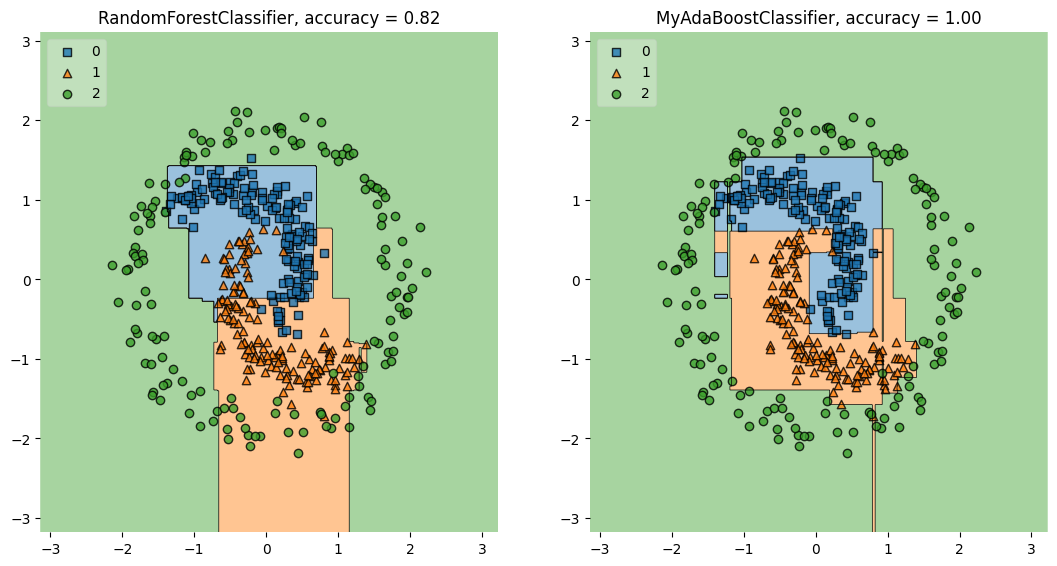

In [10]:
from sklearn.ensemble import RandomForestClassifier

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(13, 6.5))

for classifier, axis in zip(
        (
            RandomForestClassifier(10, max_depth=3), # put models (Boosting and Forest) with equivalent parameters for trees (e.g. max_depth=3/4, etc)
            MyAdaBoostClassifier(n_estimators=10, base_estimator=DecisionTreeClassifier, max_depth=3, seed=42)# see example with GaussianNB model below
        ), axes):
    make_clf_plot(classifier, axis)

Видим, что несмотря на одинаковое количество разделяющих сегментов (поскольку количество и глубина деревьев зафиксированы), бустинг справляется с классификацией сильно лучше, особенно на сложных примерах, где данные нелинейны и находятся близко друг к другу. Однако такая гибкость может привести к переобучению:

<ipython-input-6-d09611f9b2e6>:144: RuntimeWarning: invalid value encountered in divide
  return exp_el / sum_exp
<ipython-input-6-d09611f9b2e6>:144: RuntimeWarning: invalid value encountered in divide
  return exp_el / sum_exp


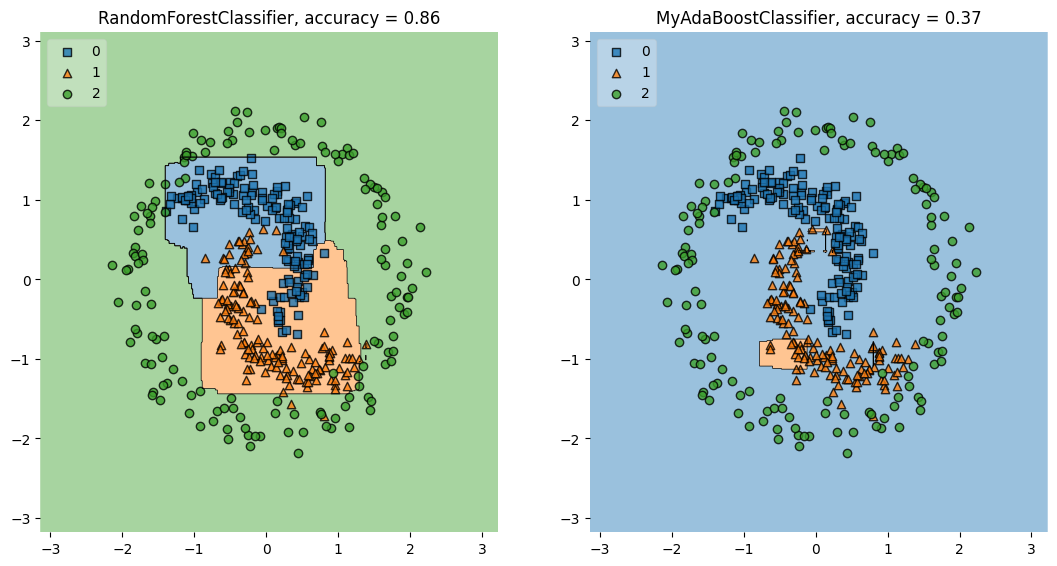

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(13, 6.5))

for classifier, axis in zip(
        (
            # put here both models with many estimators
            RandomForestClassifier(500, max_depth=3),
            MyAdaBoostClassifier(n_estimators=500, base_estimator=DecisionTreeClassifier, max_depth=3, seed=42)
        ), axes):
    make_clf_plot(classifier, axis)

В зависимости от сида и удачи, вы можете поймать моменты, когда адаптивный бустинг рисует островки одного класса внутри региона другого, что является одним из хороших признаков переобучения, причем все это на трейне! Поэтому число эстиматоров надо тюнить и смотреть на метрики на тесте.

Теперь попробуем забустить логистическую регрессию, чтобы порадоваться какой мощный метод мы заимплементировали.

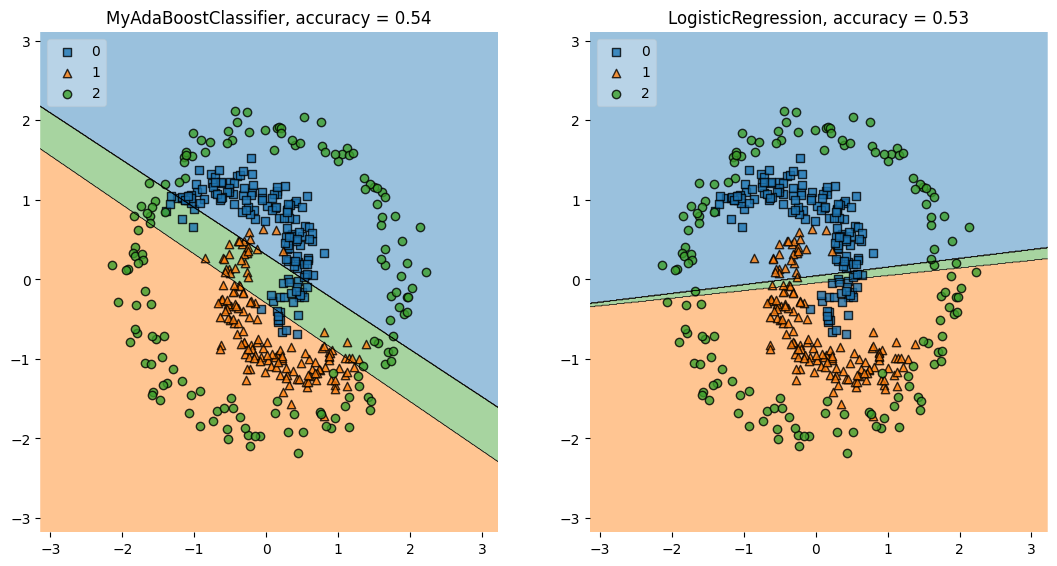

In [12]:
from sklearn.linear_model import LogisticRegression

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(13, 6.5))

for classifier, axis in zip(
    (MyAdaBoostClassifier(n_estimators=100, base_estimator=LogisticRegression, seed=42),
     LogisticRegression(C=0.001)), axes):
            # Boost logistic regression and plot alongside with just one logreg, regularize it slightly
    make_clf_plot(classifier, axis)

Видим, что качество очень далеко от ожидаемого, что же случилось?

<details>

  <summary><b>Нажмите однократно, чтобы раскрыть</b></summary>

Поскольку предсказание формируется из линейной комбинации скоров базовых моделей (см формулу выше), мы все равно получаем линейную модель, которая не может разделить нелинейную выборку и профита от бустинга нет..

</details>


Применим другую модель послабее, зато нелинейную, которая предсказывает гауссовы центроиды

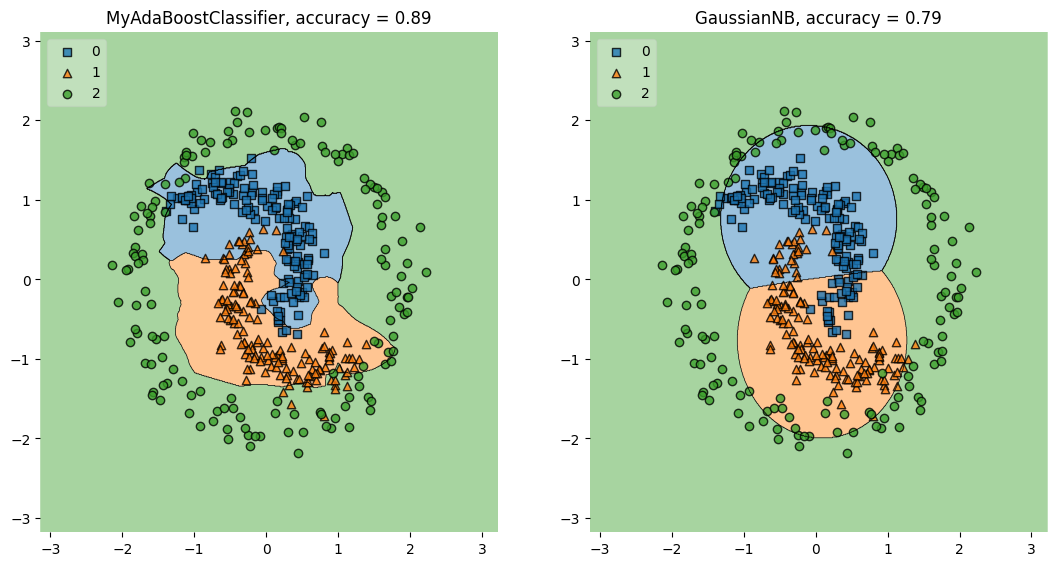

In [13]:
from sklearn.naive_bayes import GaussianNB

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(13, 6.5))

for classifier, axis in zip(
        (
                MyAdaBoostClassifier(n_estimators=30, base_estimator=GaussianNB, seed=42),
                GaussianNB()

        ), axes):
    make_clf_plot(classifier, axis)

Отлично, с адаптивным бустингом разобрались, теперь давайте имплементируем знаменитый градиентный бустинг.

#### Градиентный бустинг
Идея градиентного бустинга заключается в том, чтобы выполнить дискретную градиентную оптимизацию какой-нибудь выпуклой функции потерь, предсказывая на каждом шагу градиент специально обученным **регрессором**. Другая точка зрения состоит в том, что каждая последующая модель бустинга учится предсказывать отклонение ансамбля предыдущих от правильного значения, так что они постепенно уточняют итоговый предикт. \
Алгоритм градиентного бустинга можно прочитать в [учебнике](https://ml-handbook.ru/chapters/grad_boost/intro). Наша реализация будет иметь следующие особенности:
* Поскольку модели учатся предсказывать градиент, то вместо базовых классификаторов нам потребуются базовые **регрессоры**, мы используем регрессионные деревья из `sklearn`
* Константный лернинг рейт (гамма) для борьбы с переобучением и упрощения реализации
* Будет реализована только бинарная классификация, поскольку градиент по предсказаниям модели в случае многоклассовой классификации — это вектор по числу классов, нам потребуется `К` регрессионных деревьев на каждом шаге (каждое из них умеет предсказывать только одно число). Держите это в голове, когда используете градиентный бустинг из `sklearn`: в нем число деревьев, из которых состоит модель, на самом деле равно число_классов * `n_estimators`. Для бинарного случая такой проблемы нет, поскольку достаточного одного числа для предсказания бинарной вероятности
* Наша имплементация опирается на логиты — сырые предсказания регрессионной модели, принимающие вещественные значения. Вероятности из них по аналогии с логистической регрессией будем получать при помощи сигмоиды
* В качестве функции потерь возьмем отрицательное лог-правдоподобие. Объединяя с пунктом выше имеем такие формулы:
$$
    \text{model}(x) = h, \ \text{probability} = \sigma(h) \\
    \mathcal{L}(\text{model}, X, Y) = -\sum_{(x, y) \in X\oplus Y} y \cdot\log(\text{probability}(\text{model}(x))) + (1 - y) \cdot \log(1 - \text{probability}(\text{model}(x)))
$$

**4. (1 балл) Сдайте реализацию функции потерь в градиентном бустинге в контест.**

**5. (2 балла) Сдайте реализацию обучения классификатора в контест.**

**6. (2 балла) Сдайте реализацию предсказания в градиентном бустинге в контест.**

In [6]:
class MyBinaryTreeGradientBoostingClassifier:
    """
    *Binary* gradient boosting with trees using
    negative log-likelihood loss with constant learning rate.
    Trees are to predict logits.
    """
    big_number = 1 << 32
    eps = 1e-8

    def __init__(
            self,
            n_estimators: int,
            learning_rate: float,
            seed: int,
            **kwargs
    ):
        """
        :param n_estimators: estimators count
        :param learning_rate: hard learning rate
        :param seed: global seed
        :param kwargs: kwargs of base estimator which is sklearn TreeRegressor
        """
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.initial_logits = None
        self.rng = np.random.default_rng(seed)
        self.base_estimator = DecisionTreeRegressor
        self.base_estimator_kwargs = kwargs
        self.estimators = []
        self.loss_history = []  # this is to track model learning process

    def create_new_estimator(self, seed):
        estimator_kwargs = self.base_estimator_kwargs.copy()
        estimator = self.base_estimator(**estimator_kwargs)
        return estimator

    @staticmethod
    def cross_entropy_loss(
            true_labels: np.ndarray,
            logits: np.ndarray
    ):
        """
        compute negative log-likelihood for logits,
        use clipping for logarithms with self.eps
        or use numerically stable special functions.
        This is used to track model learning process
        :param true_labels: [n_samples]
        :param logits: [n_samples]
        :return:
        """
        probs = 1 / (1 + np.exp(-logits))
        norm_probs = np.maximum(probs, MyBinaryTreeGradientBoostingClassifier.eps)
        loss = - np.sum(true_labels * np.log(norm_probs) + (1 - true_labels) * np.log(1 - norm_probs))
        return loss

    @staticmethod
    def cross_entropy_loss_gradient(
            true_labels: np.ndarray,
            logits: np.ndarray
    ):
        """
        compute gradient of log-likelihood w.r.t logits,
        use clipping for logarithms with self.eps
        or use numerically stable special functions
        :param true_labels: [n_samples]
        :param logits: [n_samples]
        :return:
        """
        probs = 1 / (1 + np.exp(-logits))
        norm_probs = np.maximum(probs, MyBinaryTreeGradientBoostingClassifier.eps)
        gradient = probs - true_labels
        return gradient

    def fit(
            self,
            X: np.ndarray,
            y: np.ndarray
    ):
        """
        sequentially fit estimators to reduce residual on each iteration
        :param X: [n_samples, n_features]
        :param y: [n_samples]
        :return: self
        """
        self.loss_history = []
        # only should be fitted on datasets with binary target
        assert (np.unique(y) == np.arange(2)).all()
        # init predictions with mean target (mind that these are logits!)
        self.initial_logits = np.log(np.mean(y) / (1 - np.mean(y)) + MyBinaryTreeGradientBoostingClassifier.eps)
        # create starting logits
        logits = np.full_like(y, self.initial_logits, dtype=float)
        # init loss history with starting negative log-likelihood
        self.loss_history.append(self.cross_entropy_loss(y, logits))
        # sequentially fit estimators with random seeds
        for seed in self.rng.choice(
                max(self.big_number, self.n_estimators),
                size=self.n_estimators,
                replace=False
        ):
            # add newly created estimator
            self.estimators.append(self.create_new_estimator(seed))
            # compute gradient
            gradient = self.cross_entropy_loss_gradient(y, logits=logits)
            # fit estimator on gradient residual
            self.estimators[-1].fit(X, -gradient)
            # adjust logits with learning rate
            new_logits = self.estimators[-1].predict(X)
            logits += self.learning_rate * new_logits
            # append new loss to history
            self.loss_history.append(self.cross_entropy_loss(y, logits))
        return self

    def predict_proba(
            self,
            X: np.ndarray
    ):
        """
        :param X: [n_samples]
        :return:
        """
        # init logits using precalculated values
        logits = np.full(X.shape[0], self.initial_logits, dtype=float)
        # sequentially adjust logits with learning rate
        for estimator in self.estimators:
            predictions = estimator.predict(X)
            logits += self.learning_rate * predictions
        probas = 1 / (1 + np.exp(-logits))
        # don't forget to convert logits to probabilities
        return probas

    def predict(
            self,
            X: np.ndarray
    ):
        """
        calculate predictions using predict_proba
        :param X: [n_samples]
        :return:
        """
        predictions = self.predict_proba(X)
        predictions = (predictions >= 0.5).astype(int)
        return predictions

In [7]:
class Logger:
    """Logger performs data management and stores scores and other relevant information"""

    def __init__(self, logs_path: tp.Union[str, os.PathLike]):
        self.path = pathlib.Path(logs_path)

        records = []
        for root, dirs, files in os.walk(self.path):
            for file in files:
                if file.lower().endswith('.json'):
                    uuid = os.path.splitext(file)[0]
                    with open(os.path.join(root, file), 'r') as f:
                        try:
                            logged_data = json.load(f)
                            records.append(
                                {
                                    'id': uuid,
                                    **logged_data
                                }
                            )
                        except json.JSONDecodeError:
                            pass
        if records:
            self.leaderboard = pd.DataFrame.from_records(records, index='id')
        else:
            self.leaderboard = pd.DataFrame(index=pd.Index([], name='id'))

        self._current_run = None

    class Run:
        """Run incapsulates information for a particular entry of logged material. Each run is solitary experiment"""

        def __init__(self, name, storage, path):
            self.name = name
            self._storage = storage
            self._path = path
            self._storage.append(pd.Series(name=name))

        def log(self, key, value):
            self._storage.loc[self.name, key] = value

        def log_values(self, log_values: tp.Dict[str, tp.Any]):
            for key, value in log_values.items():
                self.log(key, value)

        def save_logs(self):
            with open(self._path / f'{self.name}.json', 'w+') as f:
                json.dump(self._storage.loc[self.name].to_dict(), f)

        def log_artifact(self, fname: str, writer: tp.Callable):
            with open(self._path / fname, 'wb+') as f:
                writer(f)

    @contextlib.contextmanager
    def run(self, name: tp.Optional[str] = None):
        if name is None:
            name = str(uuid.uuid4())
        # elif name in self.leaderboard.index:
        #     raise NameError("Run with given name already exists, name should be unique")
        else:
            name = name.replace(' ', '_')
        self._current_run = Logger.Run(name, self.leaderboard, self.path / name)
        os.makedirs(self.path / name, exist_ok=True)
        try:
            yield self._current_run
        finally:
            self._current_run.save_logs()


def load_predictions_dataframe(filename, column_prefix, index):
    with open(filename, 'rb') as file:
        data = np.load(file)
        dataframe = pd.DataFrame(data, columns=[f'{column_prefix}_{i}' for i in range(data.shape[1])],
                                 index=index)
        return dataframe


In [8]:
class ExperimentHandler:
    """This class perfoms experiments with given model, measures metrics and logs everything for thorough comparison"""
    stacking_prediction_filename = 'cv_stacking_prediction.npy'
    test_stacking_prediction_filename = 'test_stacking_prediction.npy'

    def __init__(
            self,
            X_train: pd.DataFrame,
            y_train: pd.Series,
            X_test: pd.DataFrame,
            y_test: pd.Series,
            cv_iterable: tp.Iterable,
            logger: Logger,
            metrics: tp.Dict[str, tp.Union[tp.Callable, str]],
            n_jobs=-1
    ):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self._cv_iterable = cv_iterable
        self.logger = logger
        self._metrics = metrics
        self._n_jobs = n_jobs

    def score_test(self, estimator, metrics, run, test_data=None):
        """
        Computes scores for test data and logs them to given run
        :param estimator: fitted estimator
        :param metrics: metrics to compute
        :param run: run to log into
        :param test_data: optional argument if one wants to pass augmented test dataset
        :return: None
        """
        if test_data is None:
            test_data = self.X_test
        test_scores = _score(estimator, test_data, self.y_test, metrics, score_params=None)
        run.log_values({key + '_test': value for key, value in test_scores.items()})



    def score_cv(self, estimator, metrics, run):
        """
        computes scores on cross-validation
        :param estimator: estimator to fit
        :param metrics: metrics to compute
        :param run: run to log to
        :return: None
        """
        cross_val_results = sklearn.model_selection.cross_validate(
            estimator,
            self.X_train,
            self.y_train,
            cv=self._cv_iterable,
            n_jobs=self._n_jobs,
            scoring=metrics
        )
        for key, value in cross_val_results.items():
            if key.startswith('test_'):
                metric_name = key.split('_', maxsplit=1)[1]
                mean_score = np.mean(value)
                std_score = np.std(value)
                run.log_values(
                    {
                        metric_name + '_mean': mean_score,
                        metric_name + '_std': std_score
                    }
                )

    def generate_stacking_predictions(self, estimator, run):
        """
        generates predictions over cross-validation folds, then saves them as artifacts
        returns fitted estimator for convinience and les train overhead
        :param estimator: estimator to use
        :param run: run to log to
        :return: estimator fitted on train, stacking cross-val predictions, stacking test predictions
        """
        if hasattr(estimator, "predict_proba"):
            method = "predict_proba"
        elif hasattr(estimator, "decision_function"):
            method = "decision_function"
        else:
            method = "predict"
        cross_val_stacking_prediction = sklearn.model_selection.cross_val_predict(
            estimator,
            self.X_train,
            self.y_train,
            cv=self._cv_iterable,
            n_jobs=self._n_jobs,
            method=method
        )
        run.log_artifact(ExperimentHandler.stacking_prediction_filename,
                         lambda file: np.save(file, cross_val_stacking_prediction))
        estimator.fit(self.X_train, self.y_train)
        test_stacking_prediction = getattr(estimator, method)(self.X_test)
        run.log_artifact(ExperimentHandler.test_stacking_prediction_filename,
                         lambda file: np.save(file, test_stacking_prediction))
        return estimator, cross_val_stacking_prediction, test_stacking_prediction

    def get_metrics(self, estimator):
        """
        get callable metrics with estimator validation
        (e.g. estimator has predict_proba necessary for likelihood computation, etc)
        """
        return _check_multimetric_scoring(estimator, self._metrics)

    def run(self, estimator: sklearn.base.BaseEstimator, name=None):
        """
        perform run for given estimator
        :param estimator: estimator to use
        :param name: name of run for convinience and consitent logging
        :return: leaderboard with conducted run
        """
        metrics = self.get_metrics(estimator)
        with self.logger.run(name=name) as run:
            # compute predictions over cross-validation
            self.score_cv(estimator, metrics, run)
            fitted_on_train, _, _ = self.generate_stacking_predictions(estimator, run)
            self.score_test(fitted_on_train, metrics, run, test_data=self.X_test)
            return self.logger.leaderboard.loc[[run.name]]

    def get_stacking_predictions(self, run_names):
        """
        :param run_names: run names for which to extract stacking predictions for averaging and stacking
        :return: dataframe with predictions indexed by run names
        """
        train_dataframes = []
        test_dataframes = []
        for run_name in run_names:
            train_filename = self.logger.path / run_name / ExperimentHandler.stacking_prediction_filename
            train_dataframes.append(load_predictions_dataframe(filename=train_filename, column_prefix=run_name,
                                                               index=self.X_train.index))
            test_filename = self.logger.path / run_name / ExperimentHandler.test_stacking_prediction_filename
            test_dataframes.append(load_predictions_dataframe(filename=test_filename, column_prefix=run_name,
                                                              index=self.X_test.index))

        return pd.concat(train_dataframes, axis=1), pd.concat(test_dataframes, axis=1)

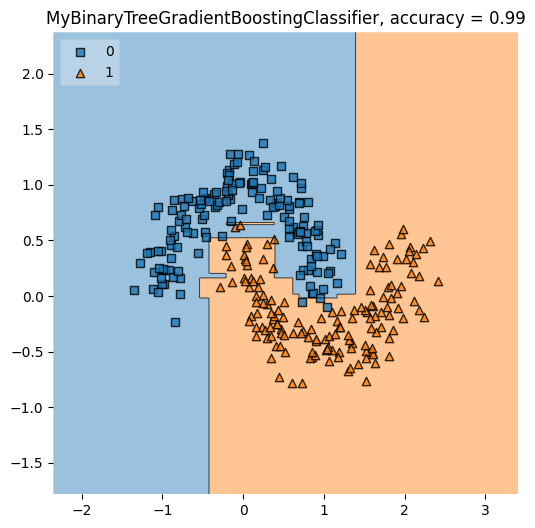

In [12]:
X, y = make_moons(n_samples=300, noise=0.15, random_state=42)


def make_clf_plot(classifier, axis):
    classifier.fit(X, y)
    plot_decision_regions(X, y, clf=classifier, legend=2, ax=axis)
    accuracy = accuracy_score(y, classifier.predict(X))
    axis.set_title(f"{classifier.__class__.__name__}, accuracy = {accuracy:2.2f}")


_ = plt.figure(figsize=(6, 6))
axis = plt.axes()
clf = MyBinaryTreeGradientBoostingClassifier(n_estimators=10, learning_rate=1.0, seed=42, max_depth=4)
make_clf_plot(clf, axis)

Посмотрим на перфоманс нашей модели с  точки зрения функции потерь (должна глобально убывать)

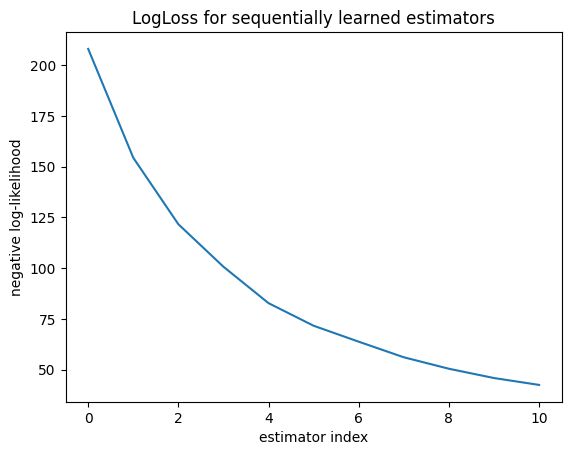

In [13]:
plt.plot(clf.loss_history)
plt.title('LogLoss for sequentially learned estimators')
plt.xlabel('estimator index')
plt.ylabel('negative log-likelihood')
plt.show();

Пронаблюдаем зависимость обучения и переобучения от лернинг рейта

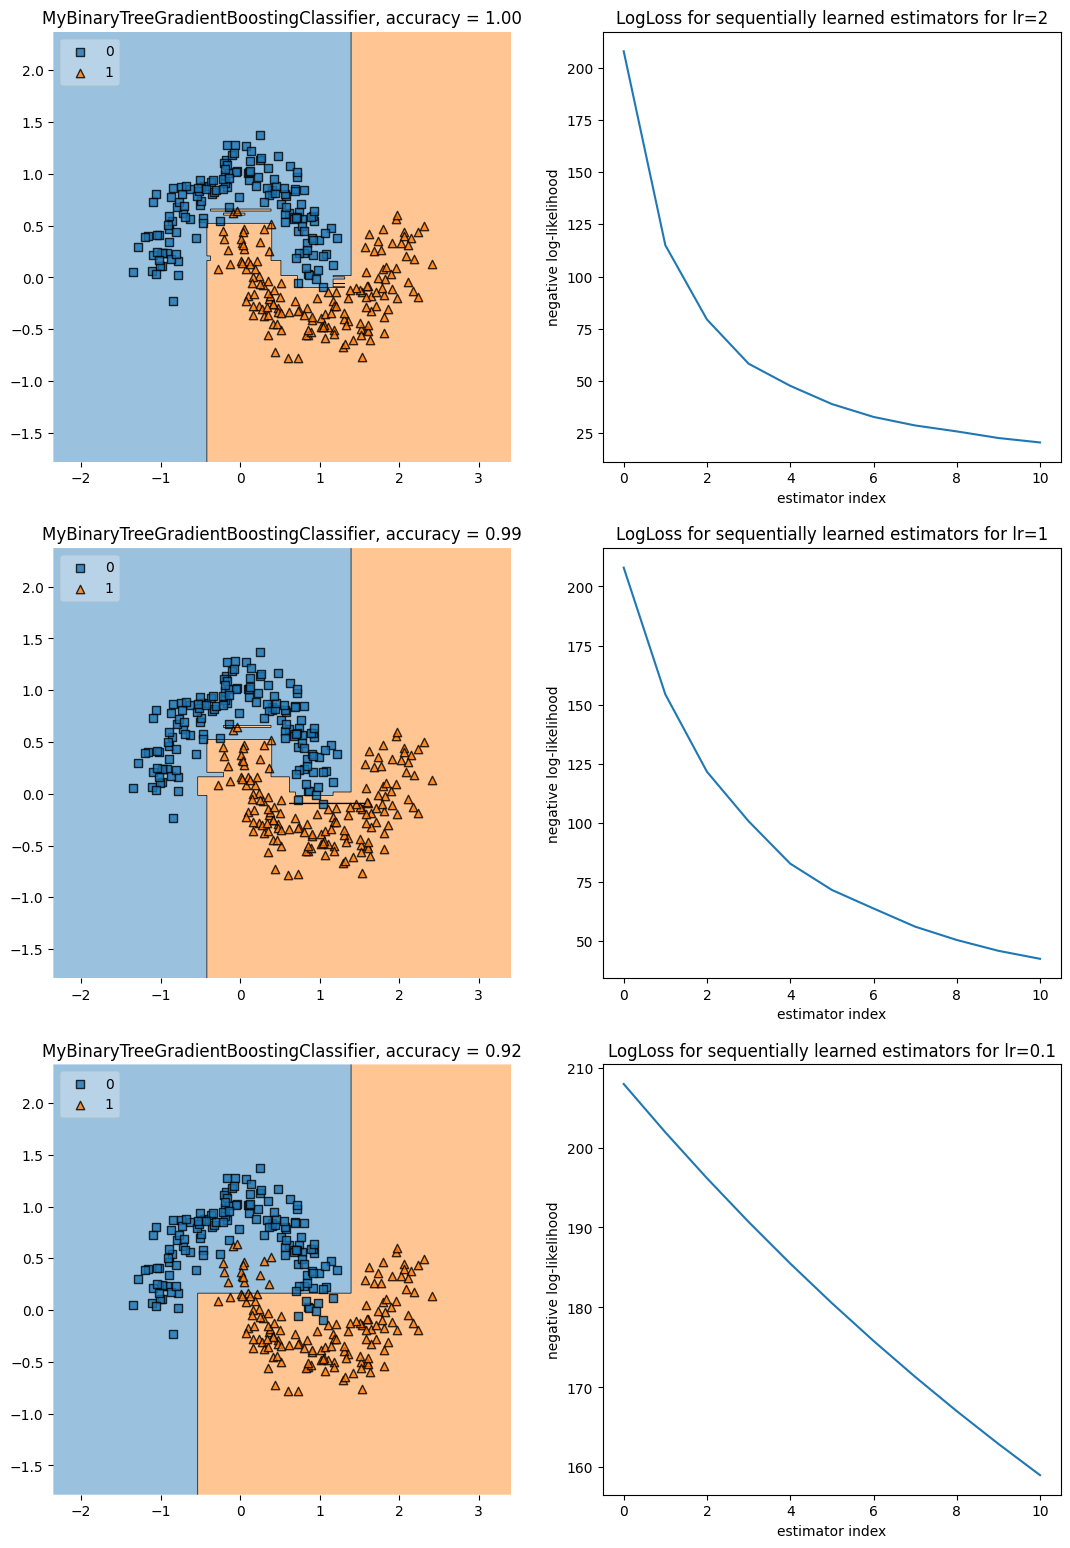

In [14]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(6 * 2 + 1, 6 * 3 + 1))

def plot_loss(classifier, axis):
    axis.plot(classifier.loss_history)
    axis.set_title(f'LogLoss for sequentially learned estimators for lr={classifier.learning_rate}')
    axis.set_xlabel('estimator index')
    axis.set_ylabel('negative log-likelihood')

for classifier, axis in zip(
        (
            MyBinaryTreeGradientBoostingClassifier(n_estimators=10, learning_rate=2, seed=42, max_depth=4),
            MyBinaryTreeGradientBoostingClassifier(n_estimators=10, learning_rate=1, seed=42, max_depth=4),
            MyBinaryTreeGradientBoostingClassifier(n_estimators=10, learning_rate=0.1, seed=42, max_depth=4)
            # put three different learning rates
        ), axes):
    make_clf_plot(classifier, axis[0])
    plot_loss(classifier, axis[1])

Видим, что модель почти не переобучается, и даже при плохих значениях лернинг рейта пытается что-то предсказать. Что будет, если менять число эстиматоров?

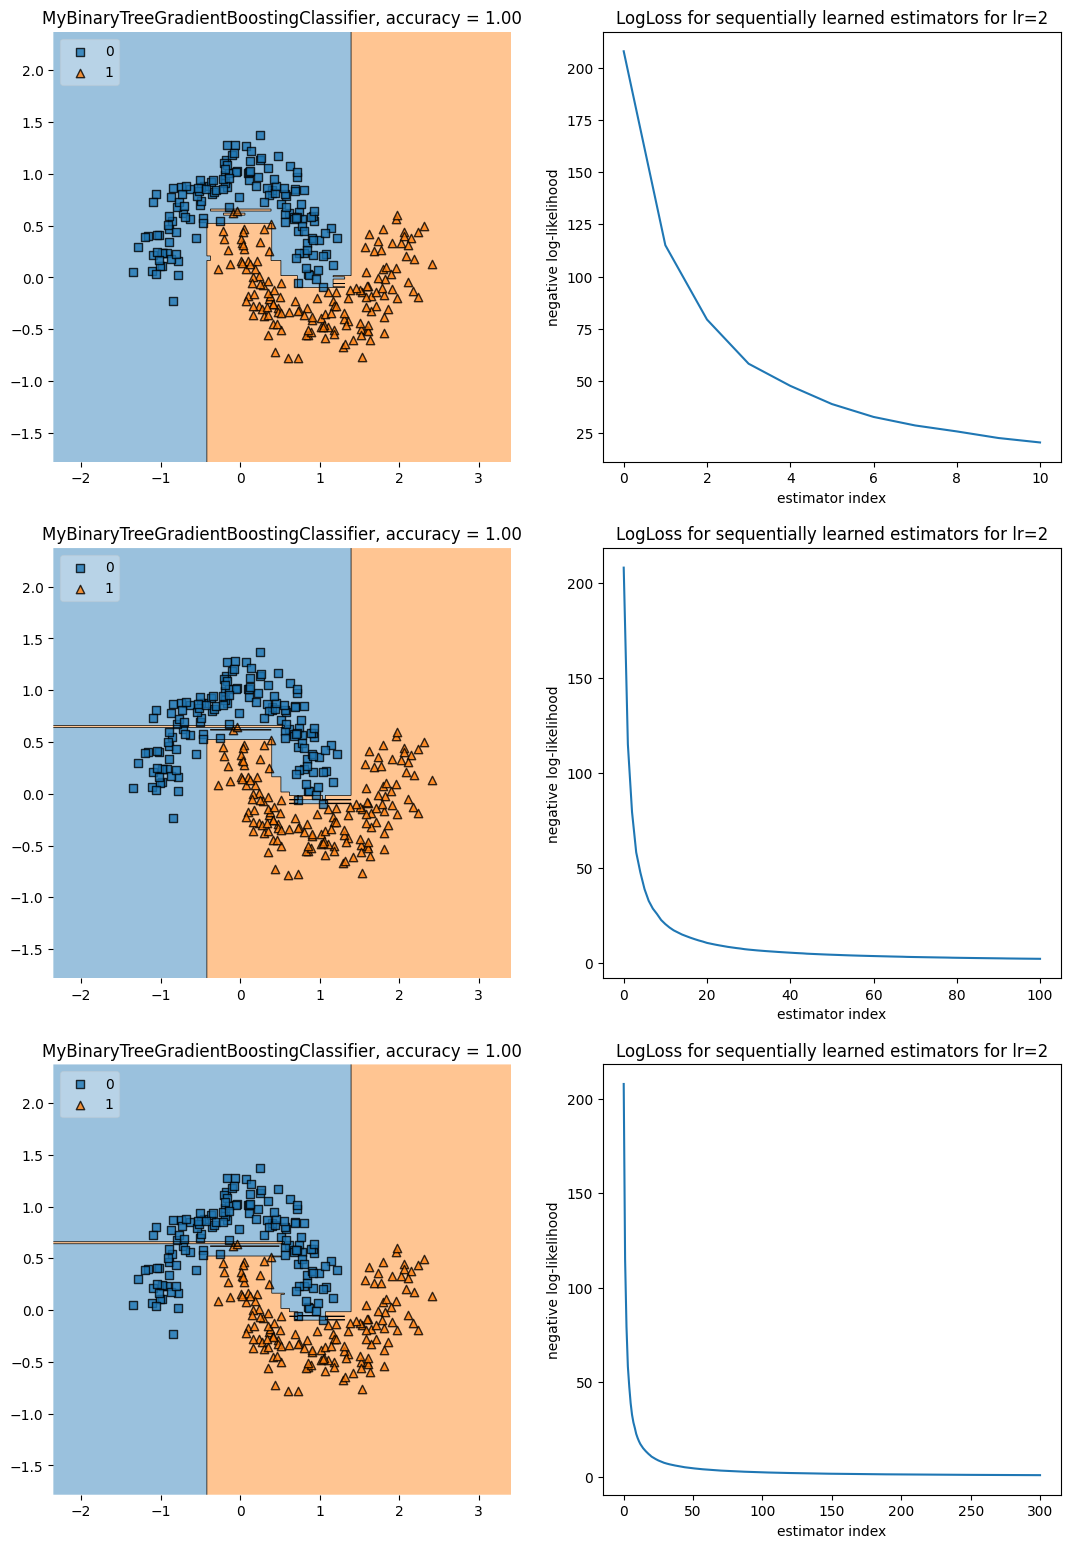

In [20]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(6 * 2 + 1, 6 * 3 + 1))

for classifier, axis in zip(
        (
            MyBinaryTreeGradientBoostingClassifier(n_estimators=10, learning_rate=2, seed=42, max_depth=4),
            MyBinaryTreeGradientBoostingClassifier(n_estimators=100, learning_rate=2, seed=42, max_depth=4),
            MyBinaryTreeGradientBoostingClassifier(n_estimators=300, learning_rate=2, seed=42, max_depth=4)
            # put three different estimator counts
        ), axes):
    make_clf_plot(classifier, axis[0])
    plot_loss(classifier, axis[1])

Видим, что есть некоторый трейд-офф между величиной градиентного шага и количеством таких шагов (что очень похоже на случай линейных моделей). В целом, поскольку шаг бустинга при больших деревьях может выполняться долго, есть смысл оставлять число эстиматоров разумным и тюнить лернинг рейт, который не влияет на скорость работы.

Насколько предикторы в градиентном бустинге равны между собой (такое любят спрашивать на собеседованиях). Давайте испортим самую первую и самую последнюю базовую модель в наших классификаторах. Подумайте, как в такой ситуации поведет себя адаптивный бустинг.

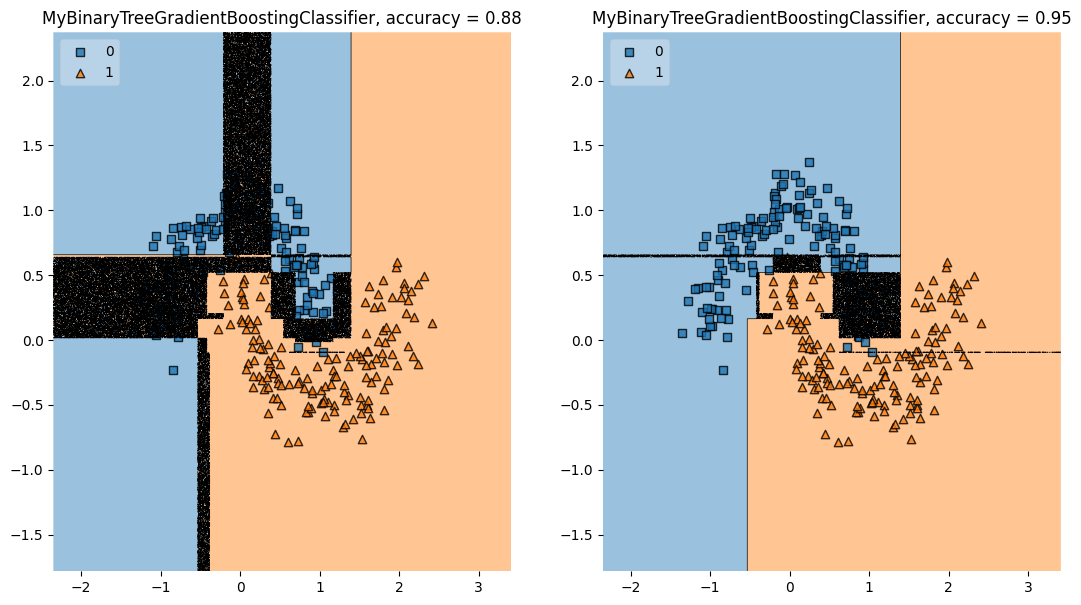

In [21]:
class ModelPredictingNoise:
    def predict(self, X):
        random_predictions = np.random.randint(2, size=X.shape[0])
        return random_predictions
    def predict_proba(self, X):
        random_noise = np.random.rand(X.shape[0], 2)
        random_noise /= random_noise.sum(axis=1, keepdims=True)
        return random_noise

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(6 * 2 + 1, 6 + 1))
for classifier, axis, spoil_id in zip(
        (
                MyBinaryTreeGradientBoostingClassifier(n_estimators=5, learning_rate=1.0, seed=42, max_depth=4),
                MyBinaryTreeGradientBoostingClassifier(n_estimators=5, learning_rate=1.0, seed=42, max_depth=4)
        ), axes, [0, -1]):
    classifier.fit(X, y)
    classifier.estimators[spoil_id] = ModelPredictingNoise()
    plot_decision_regions(X, y, clf=classifier, legend=2, ax=axis)
    accuracy = accuracy_score(y, classifier.predict(X))
    axis.set_title(f"{classifier.__class__.__name__}, accuracy = {accuracy:2.2f}")

Видим, что при достаточно больших значениях лернинг рейта, уточняющие модели дают ощутимый вклад, но все равно, первое дерево дает более весомый вклад в ответ.

#### Теперь в лабе можно пользоваться лучшей общедоступной реализацией бустинга CatBoost, ура :)

In [15]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.4 MB/s eta 0:00:00


Вернемся к нашей задаче с классификацией музыки

In [16]:
!kaggle datasets download -d purumalgi/music-genre-classification

Dataset URL: https://www.kaggle.com/datasets/purumalgi/music-genre-classification
License(s): other
  0% 0.00/1.29M [00:00<?, ?B/s]
100% 1.29M/1.29M [00:00<00:00, 55.0MB/s]


In [17]:
!unzip music-genre-classification.zip -d ./data

Archive:  music-genre-classification.zip
  inflating: ./data/submission.csv   
  inflating: ./data/test.csv         
  inflating: ./data/train.csv        


In [18]:
import pandas as pd

train_csv = pd.read_csv('./data/train.csv')
test_csv = pd.read_csv('./data/test.csv')
submission_csv = pd.read_csv('./data/submission.csv')

In [19]:
train_csv.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [20]:
test_csv.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature
0,David Bowie,Space Oddity - 2015 Remaster,73.0,0.310,0.403,NaN,-13.664,1,0.0326,0.07260,0.000093,0.1390,0.466,134.480,318027.000000,4
1,Crimson Sun,Essence of Creation,34.0,0.511,0.955,1.0,-5.059,1,0.1290,0.00040,0.000009,0.2630,0.291,151.937,220413.000000,4
2,P!nk,Raise Your Glass,78.0,0.700,0.709,7.0,-5.006,1,0.0839,0.00480,NaN,0.0289,0.625,122.019,202960.000000,4
3,Shawn Mendes,Wonder,80.0,0.333,0.637,1.0,-4.904,0,0.0581,0.13100,0.000018,0.1490,0.132,139.898,172693.000000,4
4,Backstreet Boys,Helpless When She Smiles - Radio Version,48.0,0.393,0.849,11.0,-4.114,1,0.0459,0.00421,NaN,0.1620,0.222,74.028,4.093117,4


In [21]:
submission_csv.head()

,Acoustic/Folk_0,Alt_Music_1,Blues_2,Bollywood_3,Country_4,HipHop_5,Indie Alt_6,Instrumental_7,Metal_8,Pop_9,Rock_10
0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0


В прошлый раз мы пытались предсказать жанр музыки основываясь только на вещественных фичах, которые способны были скушать наши деревья, но поскольку мы обладаем теперь более мощными моделями, давайте сделаем более мощные фичи. Тем более что это очень просто с катбустом.

Напомним наш прошлый топовый пайплайн без учета стэкинга. **Положите рядом с ноутбуком пикл индексов для разбиения из прошлой домашки, а также логи хэндлера экспериментов, чтобы продолжить существующий лидерборд.**

In [22]:
import pickle
import os
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold

filename = 'indices.pckl'
if os.path.exists(filename):
    with open(filename, 'rb') as f:
        indices = pickle.load(f)
else:
    indices = {}
    indices['train_indices'], indices['test_indices'] = train_test_split(
        np.arange(len(train_csv)),
        test_size=2996,
        stratify=train_csv['Class'],
        shuffle=True,
        random_state=0xBA0BAB
    )

    train_df = train_csv.iloc[indices['train_indices']]
    cv_splitter = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=0xBED
    )
    indices['cv_iterable'] = []
    for train_indices, val_indices in cv_splitter.split(train_df.drop('Class', axis=1), train_df['Class']):
        indices['cv_iterable'].append(
            (train_indices, val_indices)
        )
    with open(filename, 'wb+') as f:
        pickle.dump(indices, f)

In [23]:
train_indices = indices['train_indices']
test_indices = indices['test_indices']
cv_iterable = indices['cv_iterable']
X_train = train_csv.iloc[train_indices].drop('Class', axis=1)
y_train = train_csv.iloc[train_indices]['Class']
X_test = train_csv.iloc[test_indices].drop('Class', axis=1)
y_test = train_csv.iloc[test_indices]['Class']

In [24]:
logger = Logger('./logs')
scorer = ExperimentHandler(
    X_train, y_train, X_test, y_test, cv_iterable, logger,
    metrics={
        'BalancedAccuracy': 'balanced_accuracy',
        'NegLogLoss': 'neg_log_loss'
    }
)

In [25]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

forest_pipeline = Pipeline(
    [
        (
            'extract numeric features',
            ColumnTransformer(
                [
                    (
                        'drop words',
                        'drop',
                        ['Artist Name', 'Track Name']
                    )
                ],
                remainder='passthrough'
            )
        ),
        (
            'fill missing values',
            SimpleImputer(strategy='constant', fill_value=X_train.apply(pd.to_numeric, errors='coerce').max().max())
        ),
        (
            'estimator',
            RandomForestClassifier(n_estimators=200, random_state=0x5EED)
        )
    ]
)

Попробуем в нашем пайплайне применить бустинг и померить профит

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

gradboost_pipeline = Pipeline(
    [
        (
            'extract numeric features',
            ColumnTransformer(
                [
                    (
                        'drop words',
                        'drop',
                        ['Artist Name', 'Track Name']
                    )
                ],
                remainder='passthrough'
            )
        ),
        (
            'fill missing values',
            SimpleImputer(strategy='constant', fill_value=X_train.apply(pd.to_numeric, errors='coerce').max().max())
        ),
        (
            'estimator',
            GradientBoostingClassifier(n_estimators=50, random_state=0x5EED)
            # это 50 * 11 деревьев, тк у нас 11 классов
        )
    ]
)

In [27]:
scorer.logger.leaderboard

""
id


In [28]:
scorer.run(gradboost_pipeline, name='gradboost_on_old_features')

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
from catboost import CatBoostClassifier

catboost_pipeline = Pipeline(
    [
        (
            'extract numeric features',
            ColumnTransformer(
                [
                    (
                        'drop words',
                        'drop',
                        ['Artist Name', 'Track Name']
                    )
                ],
                remainder='passthrough'
            )
        ),
        (
            'fill missing values',
            SimpleImputer(strategy='constant', fill_value=X_train.apply(pd.to_numeric, errors='coerce').max().max())
        ),
        (
            'estimator',
            CatBoostClassifier(iterations=200, random_state=0x5EED)
        )
    ]
)

In [ ]:
scorer.run(catboost_pipeline, name='catboost_on_old_features')

(Катбуст пока не побеждает)

Видим, что в нашем пайплайне мы отказались от важного набора фичей — текстовых фичей. Почему они могут нам докинуть качества:

In [ ]:
intersection_of_artists = # найдите пересечение между артистами из терйна и теста
print("Example of overlap between artist names from train and test")
print(list(intersection_of_artists)[:10])
print('Count of overlapping artists:', len(intersection_of_artists))

Проверим предположение, что исполнители в среднем играют музыку в одном и том же жанре

In [ ]:
track_genre_per_artist_counts = X_train.join(y_train)[['Artist Name', 'Class']].groupby(['Artist Name', 'Class']).agg(
    count_col=pd.NamedAgg(column="Class", aggfunc="count")
)
track_genre_per_artist_counts.head()

Посмотрим, сколько артистов с более чем одним жанром, сколько у них трэков.

In [ ]:
print('Count of unique artists:', X_train['Artist Name'].nunique())
print('Count of artists with more than two genres:',
      (track_genre_per_artist_counts.groupby(level=0).count() > 1).sum().item())
top_represented_tracks_count = track_genre_per_artist_counts.groupby(level=0)['count_col'].max()
print('Mean value of top-repesented genre tracks count:', top_represented_tracks_count.mean())
print('Max value of top-repesented genre tracks count:', top_represented_tracks_count.max())
plt.bar(x=np.arange(top_represented_tracks_count.shape[0]),
        height=top_represented_tracks_count.sort_values(ascending=False))
plt.show();

Интуитивно кажется, что примеров одножанровых артистов не так много, особенно, учитывая, что оверлап с тестом не такой большой. Но они есть и надо засунуть их в модель, чтобы понять какой профит будет от этого. Только вопрос, как это сделать. Если, допустим, трактовать имя исполнителя, как категориальную фичу, то ординальность получится более 8к, а значит никакого one-hot кодирования сделать не получится. У нас будет очень разреженная фича, задача получится переопределенной и потребуется модель с большой "емкостью", чтобы запомнить, какой категории соответствует какой таргет. В этом месте у нас два пути: работать с фичей как с текстовой или использовать другие способы кодирования, научимся делать оба!

Первый вариант, закодировать таргетом, добавив для теста вариант фичи "не встречалась в трейне", напишите соответствующий кодировщик средствами `sklearn`

In [ ]:
artist_top_genre_tuples = track_genre_per_artist_counts.groupby(level=0).idxmax()['count_col'].to_list()

In [ ]:
dict(artist_top_genre_tuples)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin


class SimpleTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dict_of_artists = None

    def fit(self, X, y):
        X = pd.DataFrame(X, columns=X_train.columns)
        if isinstance(y, pd.Series):
            X['Class'] = y.values
        elif isinstance(y, np.ndarray):
            X['Class'] = y
        track_genre_per_artist_counts = # подсчитайте сколько треков данного артиста принадлежат данному жанру
        artist_top_genre_tuples = # постройте словарь для реплейса
        self.dict_of_artists = dict(artist_top_genre_tuples)
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=X_train.columns)
        X['Target Encoded Artists'] = X['Artist Name'].map(self.dict_of_artists).fillna(value=-1).astype(int)
        return X

In [ ]:
tr = SimpleTargetEncoder()
tr.fit(X_train, y_train).transform(X_train).head()

In [ ]:
tr.transform(X_test).head()

Теперь такую категориальную фичу можно преобразовать в OneHot и использовать в пайлпайне

In [ ]:
from sklearn.preprocessing import OneHotEncoder

catboost_pipeline = Pipeline(
    [
        (
            'target encode',
            ColumnTransformer(
                [
                    (
                        'Target Encode Artist Name',
                        SimpleTargetEncoder(),
                        X_train.columns
                    )
                ],
            )
        ),
        (
            'extract numeric features',
            ColumnTransformer(
                [
                    (
                        'OHE for target encoded artist names',
                        OneHotEncoder(sparse=False, handle_unknown='ignore'),
                        [16, ] # those magic numbers are used to overcome issue with improper handling of dataframes by column transformer
                    ),
                    (
                        'drop words',
                        'drop',
                        [0, 1]  # those magic numbers are used to overcome issue with improper handling of dataframes by column transformer
                    )
                ],
                remainder='passthrough'
            )
        ),
        (
            'fill missing values',
            SimpleImputer(strategy='constant', fill_value=X_train.apply(pd.to_numeric, errors='coerce').max().max())
        ),
        (
            'estimator',
            CatBoostClassifier(iterations=200, random_state=0x5EED)
        )
    ]
)

In [ ]:
scorer.run(catboost_pipeline, name='catboost_on_simple_target_encoded_features')

Стало сильно лучше!

In [ ]:
scorer.logger.leaderboard.sort_values(by='BalancedAccuracy_test', ascending=False)

На самом деле нет необходимости кодировать текстовые фичи мануально — ведь катбуст может работать с текстовыми из коробки, для этого он применяет Bag of Words/TF-IDF методы. Поскольку ключевые слова из названий исполнителей и песен могут нести положительный сигнал, мы ожидаем прирост качества от этого подхода. А еще, как следует из названия, он поддерживает категориальные фичи множеством разных методов их кодирования. Воспользуйтесь этим и постройте сильную модель.

In [ ]:
class PandasSimpleImputer(SimpleImputer):
    """
    A wrapper around `SimpleImputer` to return data frames with columns.
    """

    def fit(self, X, y=None):
        self.columns = X.columns
        return super().fit(X, y)

    def transform(self, X):
        return pd.DataFrame(super().transform(X), columns=self.columns)

strong_catboost_pipeline = Pipeline(
    [
        (
            'fill missing values',
            PandasSimpleImputer(strategy='constant', fill_value=X_train.apply(pd.to_numeric, errors='coerce').max().max())
        ),
        (
            'estimator',
            CatBoostClassifier(SOMETHING) # разберитесь в параметрах катбуста, чтобы он обучался на текстовых и категориальных фичах
        )
    ]
)

In [ ]:
strong_catboost_pipeline.fit(X_train, y_train)

Проверим только качество на тесте, чтобы не ждать, когда катбуст обучится на всех фолдах.

In [ ]:
from sklearn.metrics import balanced_accuracy_score
predictions = strong_catboost_pipeline.predict(X_test)
print('strong catboost balanced accuracy on test:', balanced_accuracy_score(y_test, predictions))
print('top balanced accuracy from our previous results is:', scorer.logger.leaderboard['BalancedAccuracy_test'].max())

Отрефлексируйте полученный результат.